In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from pathlib import Path
import pandas as pd
from PIL import Image
from weavingtools.annotation_tools import *
from weavingtools.annotation_tools import plot_by_record, open_image
from weavingtools.linkage_tools import *
from weavingtools.embedding_tools import *
import scipy.spatial as sp
import ipyannotations.generic
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
sns.set()

In [3]:
def plot_record_pair(record_pair):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
    
    for i in range(2):
       
        record = collection_df[collection_df.record_id==record_pair[i]]
        print(record.record_id.values[0])
        img_path = record.img_path.values[0]
        description = soft_wrap_text(record.record_id.values[0] + ' '  + record.description.values[0])
        img = Image.open(img_path)
        #img.resize((250, 2500))
        axes[i].imshow(img)
        axes[i].set_title(description, fontsize = 18)
        axes[i].axis('off')
         
    plt.show()



In [4]:
collection_db = load_db("hw",'heritage_weaver','google/siglip-base-patch16-224')
collection_df = pd.read_csv('data/heritage_weaver_data.csv')
out_path = Path('annotations')
out_path.mkdir(exist_ok=True)

## Retrieval Based on Text Prompts

In [5]:

top_n = 20
annotator = 'KB'

In [6]:
query = 'a radio transistor'
experiment = '1'

In [7]:
# retrieve records
if experiment == '1':
    filters = {'modality':'image'}
elif experiment == '2':
    filters = {'modality':'text'}
elif experiment == '3':
    filters = {}
results = collection_db.query(query_texts=[query],where=filters, n_results=top_n)
query_df = get_query_results(results, collection_df, source='img_url') # collection_df,
inputs = list(query_df.to_records())


In [8]:
inputs[0]

(0, 0.15662253, 'co8608317', 'https://coimages.sciencemuseumgroup.org.uk/335/51/medium_2018_0412__0001_.jpg', 'National Panasonic Super Sensitive 10 Transistor R-307.\n\nNational Panasonic Super Sensitive 10 Transistor R-307, by Panasonic, Japan, c.1963 This is a rare short-wave radio receiver with a leather case, made by Panasonic in Japan in the early 1960s. Made and sold in the Far East, this three-band radio was one of the earliest such short-wave receiver to bring affordable long-distance listening to the public in an easily portable form. Developed for the Far Eastern market where radio broadcasting and listening were often strictly controlled and hence demand for long-distance reception was high, there were no comparable devices available in Britain in the early 1960s.; This is a rare short-wave radio receiver with a leather case, made by Panasonic in Japan in the early 1960s. Made and sold in the Far East, this three-band radio receiver was one of the earliest such short-wave a

In [9]:
labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['relevant', 'not relevant'], allow_freetext=False,
        display_function=plot_by_record)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(inputs.pop(0))
    except IndexError:
        print("Finished.")
        
widget.on_submit(store_annotations)
widget.display(inputs.pop(0))
widget

ClassLabeller(children=(Box(children=(Output(layout=Layout(margin='auto', min_height='50px')),), layout=Layout…

In [10]:
query_df.shape,len(labels)

((44, 4), 0)

In [11]:
query_df['labels'] = labels[:top_n]
query_df['query'] = query
query_df['experiment'] = experiment
query_df.to_csv(out_path / f'{annotator}_{time.time()}.csv')
#results = collection_db.query(query_texts=[query],where=filters, n_results=top_n)

ValueError: Length of values (0) does not match length of index (44)

In [ ]:
# #Visual prompting optional at the moment, integrate later
# idx = 4
# record = collection_df.iloc[idx]
# results = collection_db.query(query_uris=[record.img_path],n_results=top_n, where=filters) # 
# #Image.open(record.img_path)
# query_df = plot_query_results(results, collection_df,source='img_path')

# Link Annotation

In [38]:
annotator = 'KB'
num_annotations = 10
coll1, coll2 = 'smg','nms'
percentile = 99.0  #99.95 | False
threshold = 0.8
randomize = True


In [39]:
experiment = '1'

In [41]:
if experiment == '1':
    modality1, modality2 = 'image','image'
    agg_func = 'max' 
elif experiment == '2':
    modality1, modality2 = 'text','text' 
    agg_func = 'max' 
elif experiment == '3':
    modality1, modality2 = 'text','text' 
    experiment_id = '3'
    agg_func = 'mean' 

edges, similarities, inputs = get_edges(collection_db,coll1,coll2, modality1, modality2, agg_func,percentile, threshold ); len(edges)

Get inputs...
Compute similarities...
--- Get similarities ---
--- Using 0.759627968792046 as threshold ---
--- Aggregate similarities by record ---
--- Threshold similarities and binarize ---
Retrieve edges...


103268

In [ ]:
if experiment == '4':
    image_edges, similarities, inputs = get_edges(collection_db,coll1,coll2, 'image','image', 'max', 99.5  , threshold )
    text_edges, similarities, inputs =  get_edges(collection_db,coll1,coll2, 'text','text', 'max', 99.5  , threshold )
    edges = list(set(image_edges).intersection(set(text_edges))); len(edges)

9556443

In [ ]:
if randomize:
    random.seed(42)
    random.shuffle(edges)
img_pairs = edges[:num_annotations]
to_annotate = img_pairs.copy()

labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['same object', 'same category', 'same materials','no link'], allow_freetext=True,
        display_function=plot_record_pair)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(img_pairs.pop(0))
    except IndexError:
        print("Finished.")
widget.on_submit(store_annotations)
widget.display(img_pairs.pop(0))
widget


In [ ]:
annotations_df = pd.DataFrame(to_annotate, columns=['coll1','coll2'])
annotations_df['labels'] = labels[:num_annotations]
annotations_df['experiment'] = experiment
annotations_df.to_csv(out_path / f'{annotator}_{time.time()}')

## With filtered Edges

In [54]:
from weavingtools.linkage_tools import filter_edges_by_keywords
keywords = ['telephone','phone']
filtered_edges = filter_edges_by_keywords(edges,collection_db,keywords,1000)
len(filtered_edges), len(edges)

(17314, 103268)

In [55]:
if randomize:
    random.seed(42)
    random.shuffle(filtered_edges)
img_pairs = filtered_edges[:num_annotations]
to_annotate = img_pairs.copy()

labels = []

widget = ipyannotations.generic.ClassLabeller(
        options=['same object', 'same category', 'same materials','no link'], allow_freetext=True,
        display_function=plot_record_pair)


def store_annotations(entity_annotation):
    labels.append(entity_annotation)
    try:
        widget.display(img_pairs.pop(0))
    except IndexError:
        print("Finished.")
widget.on_submit(store_annotations)
widget.display(img_pairs.pop(0))
widget


ClassLabeller(children=(Box(children=(Output(layout=Layout(margin='auto', min_height='50px')),), layout=Layout…

In [ ]:
annotations_df = pd.DataFrame(to_annotate, columns=['coll1','coll2'])
annotations_df['keywords'] = '<SEP>'.join(keywords)
annotations_df['labels'] = labels[:num_annotations]
annotations_df['experiment'] = experiment
annotations_df.to_csv(out_path / f'{annotator}_{time.time()}')

### Link Comparison

In [ ]:
collection_db = load_db("hw",'heritage_weaver','google/siglip-base-patch16-224')
collection_df = pd.read_csv('data/heritage_weaver_data.csv')

# Fin.

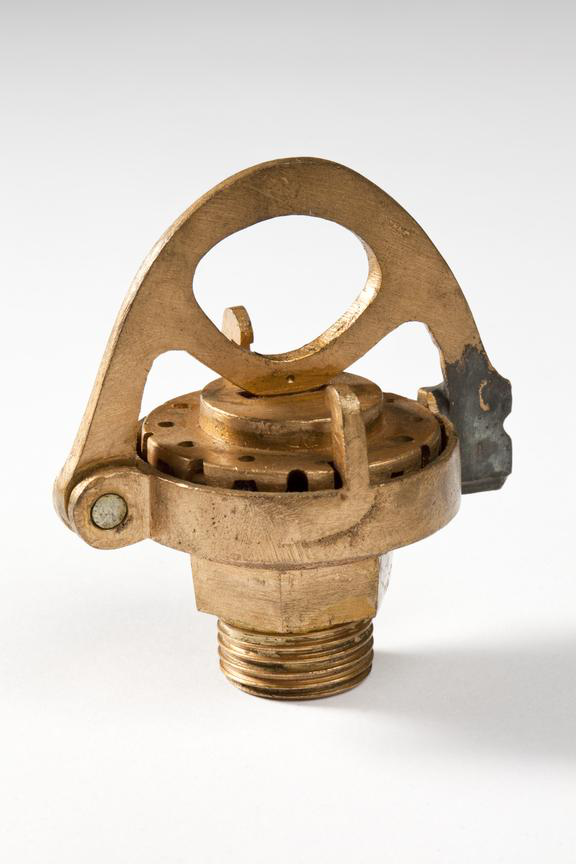

In [14]:
import requests
from PIL import Image
img_uri = 'https://coimages.sciencemuseumgroup.org.uk/131/627/medium_cd0650_024_110329_2009_28_34_sprinkler_head.jpg'
data = requests.get(img_uri)
img = Image.open(io.BytesIO(data.content))
img